# Written Exercise 5.

Evaluate the performance of the three methods (PGD with clipping, PGD with projection, and CWL2) in
terms of success, quantitative distortion measures, and subjective (human) distortion perception.


In order to offer a fair comparison, you will have to keep as many settings as possible fixed and consistent
across methods while finding good settings for the parameters not shared by the methods. That is, the c
parameter of PGD is not comparable to either c or k parameters of CWL2 while the number of steps and the
model and instances being attacked should be identical.


Include enough information about your evaluation that it can be replicated, visualize the quantitative results, and describe the qualitative results.


[participation bonus] In a public Piazza post, post the parameters you have found to have the best attack
performance. After the due date, post the conclusions of this exercise.

### Import Utility Tools 

In [1]:
%matplotlib agg
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from tqdm.notebook import tqdm

from IPython.display import clear_output

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import gridspec

import hw4_utils
import hw4_mnist

# nicer color map for visualizing both positive and negative attributions
hot = cm.get_cmap('hot', 128)
cool = cm.get_cmap('cool', 128)
binary = cm.get_cmap('binary', 128)
hotcold = np.vstack((binary(np.linspace(0,1,128)) * cool(np.linspace(0, 1, 128)),
                     hot(np.linspace(0, 1, 128))))
hotcold_cmap = ListedColormap(hotcold, name='hotcold')

# for latex in matplotlib:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

mnist_data = hw4_mnist.load_data()

### Load Model

In [2]:
m = hw4_mnist.MNISTModel()
#m._prepare_model() # retrain and save model
m.load()

### Show Attack Function

Used to show the before after of attacking an image.

In [3]:
import hw4_part1
hw4_part1.tqdm = tqdm

def show_attack(attacker, idxs, dat):  
    X = dat.X[idxs]
    Y = dat.Y[idxs]
    
    Xp = att.attack_batch(X, Y)

    for x, xp, yt, idx in list(zip(X, Xp, Y, idxs)):    
        y  = np.argmax(m.model.predict(x [np.newaxis, :, :, :])[0])
        yp = np.argmax(m.model.predict(xp[np.newaxis, :, :, :])[0])
    
        d = (x-xp).flatten()

        dnorms, dnorms_str = hw4_utils.norms(np.expand_dims(d, axis=0))
    
        lim = max(abs(np.min(d)), abs(np.max(d)))
        # make colorbar limits symmetric, with black being 0
    
        print(f"{yt}: {y} -> {yp} {dnorms_str}")

        fig = plt.figure(figsize=(6.5,3))
        gs = gridspec.GridSpec(1,3, width_ratios=[2,2,2])
        axs = [plt.subplot(gs[i]) for i in range(3)]
    
        fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.05, hspace=0)
    
        axs[0].set_axis_off()
        axs[1].set_axis_off()
        axs[2].set_axis_off()
    
        axs[0].imshow(x[:,:,0])
        axs[1].imshow(xp[:,:,0])
        c = axs[2].imshow((xp-x)[:,:,0], cmap=hotcold_cmap, vmin=-lim, vmax=lim)
        
        cax = fig.add_axes([axs[2].get_position().x1+0.01,
                            axs[2].get_position().y0,
                            0.1,
                            axs[2].get_position().y1 - axs[2].get_position().y0])
        
        fig.colorbar(mappable=c, cax=cax)
        
        fig.suptitle(f"instance={idx}, {y} $\\rightarrow$ {yp}, {dnorms_str}\n{str(att)}")
    
        display(fig)
        
    plt.close('all')

### Determin which parameter values to sweep over

For the PGD attack, c will be swept from 0.1 to 0.9 in increments of 0.1.

For the CWL2 attack, c will be swept from 1 to 10 in increments of 10. k will be swept from 0 to 1 in increments of 0.1.

In [4]:
# Determine parameters to sweep over
PGD_c_sweep = np.arange(0.05,0.55,0.05)
CWL2_c_sweep = np.arange(1,11,1)
CWL2_k_sweep = np.arange(0,1.1,0.1)

# Store resulting Success rate
PGD_clip_success = np.zeros(PGD_c_sweep.shape[0])
PGD_project_success = np.zeros(PGD_c_sweep.shape[0])
CWL2_success = np.zeros((CWL2_c_sweep.shape[0],CWL2_k_sweep.shape[0]))

# Store resulting L2 Distortion rate
PGD_clip_L2 = np.zeros(PGD_c_sweep.shape[0])
PGD_project_L2 = np.zeros(PGD_c_sweep.shape[0])
CWL2_L2 = np.zeros((CWL2_c_sweep.shape[0],CWL2_k_sweep.shape[0]))

### Sweep PGD attacks (clip and project) and store values

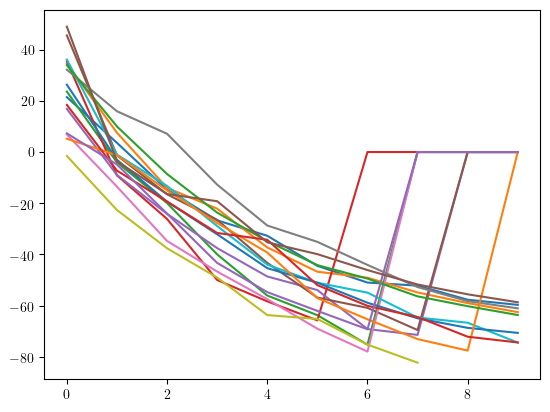

Success rate:  0.8125
Mean Distortion:  $L_0$=328.4615, $L_1$=115.8990, $L_2$=9.0234, $L_\infty$=1.0000


In [33]:
for i in range(PGD_c_sweep.shape[0]):
    
    temp = PGD_c_sweep[i]
    
    # Clip attack
    att = hw4_part1.PGDAttacker(
        model=m,
        num_steps = 10,
        target=5,
        learning_rate_decay=0.9,
        learning_rate=1.0,
        step_mode="clip",
        c=temp
    )
    
    success, distort = att.evaluate(
        X=mnist_data.train.X[0:16*1],
        Y=mnist_data.train.Y[0:16*1],
        display_progress=True
    )
    
    PGD_clip_success[i] = success
    PGD_clip_L2[i] = distort[2]
    
    # Projection attack
    att = hw4_part1.PGDAttacker(
        model=m,
        num_steps = 10,
        target=5,
        learning_rate_decay=0.9,
        learning_rate=1.0,
        step_mode="project",
        c=temp
    )
    
    success, distort = att.evaluate(
        X=mnist_data.train.X[0:16*1],
        Y=mnist_data.train.Y[0:16*1],
        display_progress=True
    )
    
    PGD_project_success[i] = success
    PGD_project_L2[i] = distort[2]    
    
    

In [34]:
# Print the success rates of PGD Clip and Project Attack
print('c indices:', PGD_c_sweep)
print("Clip success rate:", PGD_clip_success)
print("Project success rate:", PGD_project_success)

c indices: [0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]
Clip success rate: [0.     0.     0.     0.0625 0.1875 0.5    0.875  0.8125 0.875  0.875 ]
Project success rate: [0.125  0.375  0.6875 0.875  0.875  0.875  0.875  0.875  0.8125 0.8125]


In [35]:
# Print the LW distortion  of PGD Clip and Project Attack
print('c indices:', PGD_c_sweep)
print("Clip L2 rate:", PGD_clip_L2)
print("Project L2 rate:", PGD_project_L2)

c indices: [0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]
Clip L2 rate: [       nan        nan        nan 3.24909806 3.95951748 4.72459316
 5.41453123 5.96055889 6.51236296 7.04524517]
Project L2 rate: [3.29444122 4.25842142 5.01855135 5.67415714 6.25249529 6.84476852
 7.40008688 7.93854618 8.50049019 9.02336693]


### Success rate similarity

clip at c = 0.2, success = 0.6875, distortion = 3.412

project at c = 0.05, success = 0.625, distortion = 2.99

### Distortion L2 Similarity

clip at c = 0.15, distortion = 2.55, success = 0.31

project at c = 0.05, distortion = 2.99, success = 0.625

### Analysis

The projection method seems to work better when we look at similar distortion cases. slightly higher distortion but twice the sucess rate. Takes a even higher distortion value to get similar success rate from clip to project

### Sweep CWL2 attacks

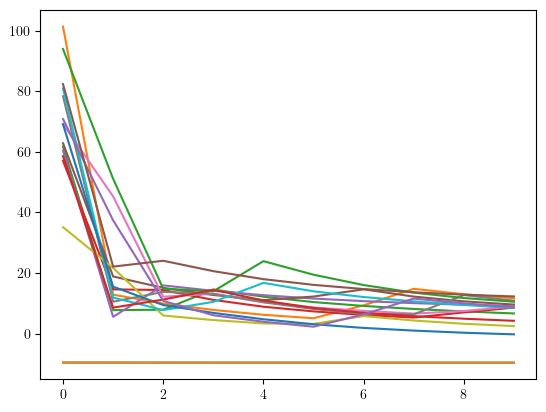

Success rate:  0.875
Mean Distortion:  $L_0$=784.0000, $L_1$=46.9769, $L_2$=3.9532, $L_\infty$=0.9815


In [36]:
import itertools

for i,j in itertools.product(range(CWL2_c_sweep.shape[0]),range(CWL2_k_sweep.shape[0])):
    
    temp_c = CWL2_c_sweep[i]
    temp_k = CWL2_k_sweep[j]
    
    # Clip attack
    att = hw4_part1.CWL2Attacker(
        model=m,
        num_steps=10,
        target=5,
        learning_rate=1.0,
        learning_rate_decay=0.9,
        k=temp_k,
        c=temp_c
    )
    
    success, distort = att.evaluate(
        X=mnist_data.train.X[0:16*1],
        Y=mnist_data.train.Y[0:16*1],
        display_progress=True
    )
    
    CWL2_success[i,j] = success
    CWL2_L2[i,j] = distort[2]

In [37]:
CWL2_success

array([[0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    ],
       [0.125 , 0.1875, 0.1875, 0.1875, 0.25  , 0.25  , 0.3125, 0.3125,
        0.3125, 0.3125, 0.3125],
       [0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.8125, 0.8125, 0.8125,
        0.8125, 0.8125, 0.8125],
       [0.6875, 0.8125, 0.875 , 0.875 , 0.875 , 0.875 , 0.875 , 0.875 ,
        0.875 , 0.875 , 0.875 ],
       [0.6875, 0.875 , 0.875 , 0.875 , 0.875 , 0.875 , 0.875 , 0.875 ,
        0.875 , 0.875 , 0.875 ],
       [0.5625, 0.75  , 0.75  , 0.75  , 0.875 , 0.875 , 0.875 , 0.875 ,
        0.875 , 0.875 , 0.875 ],
       [0.875 , 0.875 , 0.875 , 0.875 , 0.875 , 0.875 , 0.875 , 0.875 ,
        0.875 , 0.875 , 0.875 ],
       [0.6875, 0.875 , 0.875 , 0.875 , 0.875 , 0.875 , 0.875 , 0.875 ,
        0.875 , 0.875 , 0.875 ],
       [0.8125, 0.8125, 0.8125, 0.875 , 0.875 , 0.875 , 0.875 , 0.875 ,
        0.875 , 0.875 , 0.875 ],
       [0.875 , 0.875 , 0.875 , 0.875 , 0.875 , 0.875 ,

In [38]:
CWL2_L2

array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan],
       [3.36260891, 3.16691566, 3.17777133, 3.17777133, 3.19927335,
        3.19927335, 3.1326797 , 3.1363759 , 3.1363759 , 3.16976523,
        3.16976523],
       [2.99495196, 3.02078938, 2.96625662, 2.92718339, 2.97722769,
        2.97812915, 3.00620818, 3.03506732, 3.05233383, 3.08782029,
        3.08754182],
       [3.07864523, 3.08419013, 3.10459566, 3.1163938 , 3.12603807,
        3.14961052, 3.14961052, 3.17834783, 3.18625712, 3.19067693,
        3.20120287],
       [3.1898582 , 3.19859338, 3.19643402, 3.20815802, 3.23068976,
        3.25087023, 3.25282884, 3.2724402 , 3.28046107, 3.31008291,
        3.31631327],
       [3.17663884, 3.22406793, 3.23849487, 3.234025  , 3.35050607,
        3.35415077, 3.37009597, 3.38232946, 3.37199664, 3.38751435,
        3.42345548],
       [3.40151334, 3.40781856, 3.41731381, 3.44493055, 3.

### Qualitative analysis of attacks

First print images for clip PGD attack with selected settings.

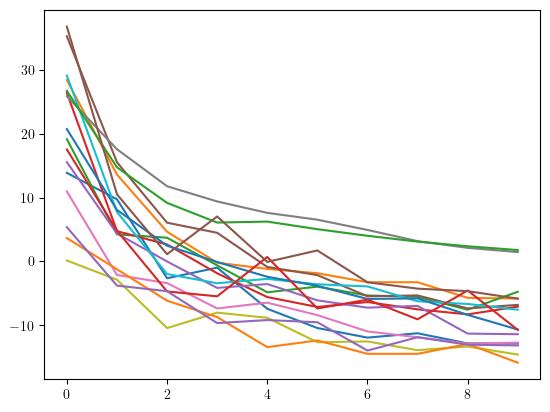

Success rate:  0.875
Mean Distortion:  $L_0$=453.2857, $L_1$=100.3942, $L_2$=5.4145, $L_\infty$=0.3500


5: 5 -> 5 $L_0$=445.0000, $L_1$=92.1950, $L_2$=5.1730, $L_\infty$=0.3500


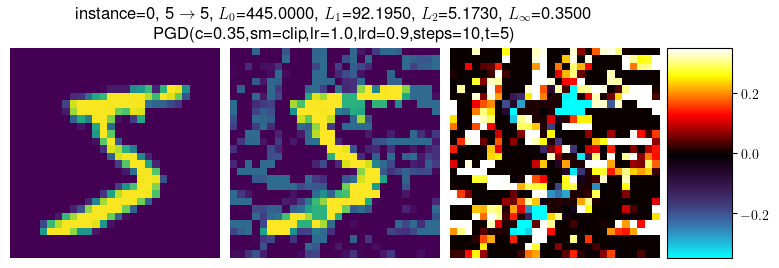

0: 0 -> 5 $L_0$=466.0000, $L_1$=103.6958, $L_2$=5.5701, $L_\infty$=0.3500


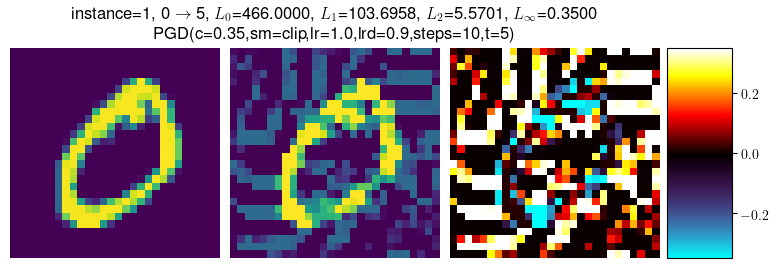

4: 4 -> 5 $L_0$=452.0000, $L_1$=95.9738, $L_2$=5.1535, $L_\infty$=0.3500


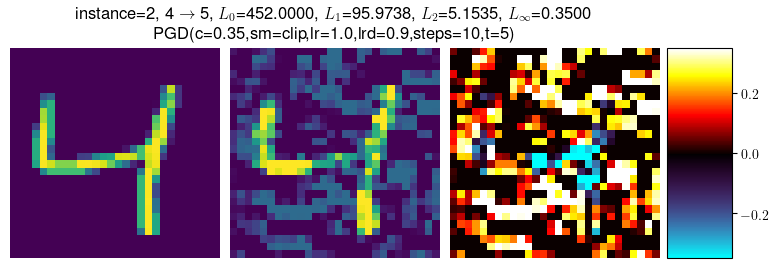

1: 1 -> 5 $L_0$=429.0000, $L_1$=95.7624, $L_2$=5.2597, $L_\infty$=0.3500


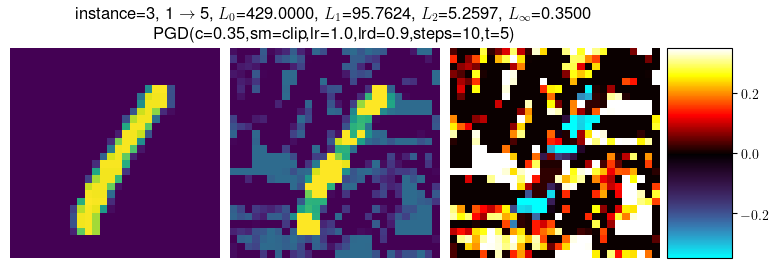

9: 9 -> 5 $L_0$=482.0000, $L_1$=110.9877, $L_2$=5.7048, $L_\infty$=0.3500


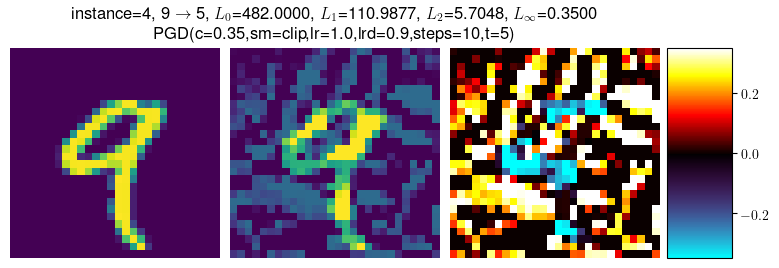

2: 2 -> 5 $L_0$=460.0000, $L_1$=105.5332, $L_2$=5.5995, $L_\infty$=0.3500


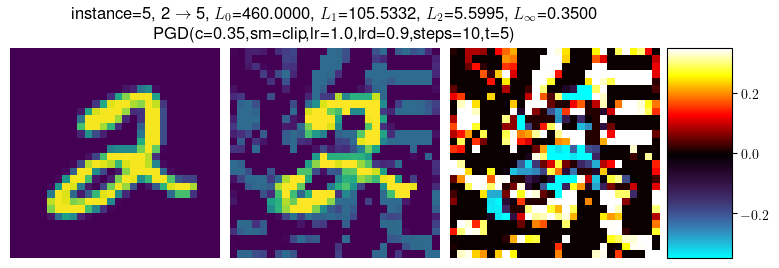

1: 1 -> 5 $L_0$=421.0000, $L_1$=97.9735, $L_2$=5.4133, $L_\infty$=0.3500


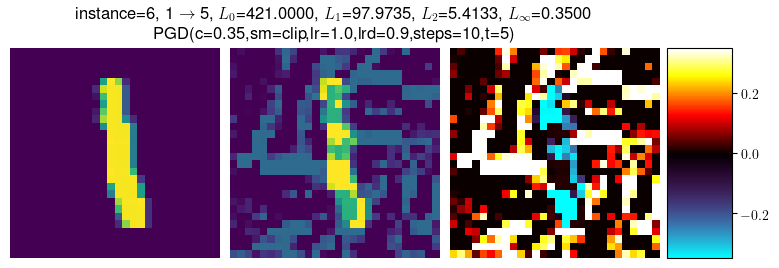

3: 3 -> 5 $L_0$=466.0000, $L_1$=100.0580, $L_2$=5.4345, $L_\infty$=0.3500


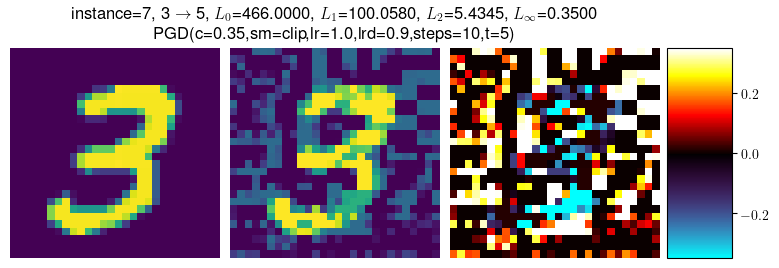

1: 1 -> 5 $L_0$=430.0000, $L_1$=97.9092, $L_2$=5.3476, $L_\infty$=0.3500


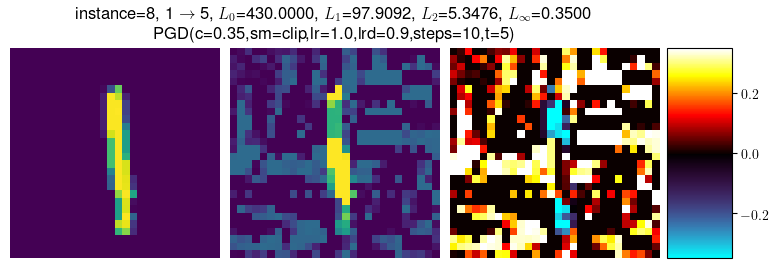

4: 4 -> 5 $L_0$=461.0000, $L_1$=97.3311, $L_2$=5.2137, $L_\infty$=0.3500


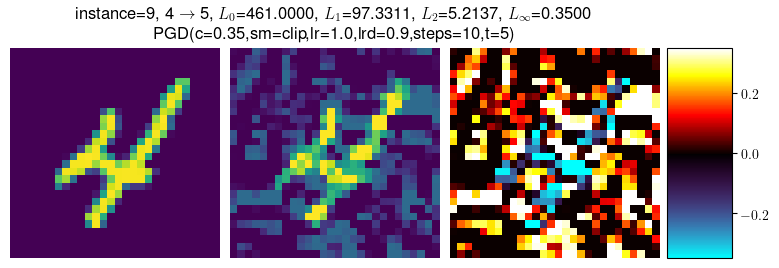

3: 3 -> 5 $L_0$=461.0000, $L_1$=97.7639, $L_2$=5.3350, $L_\infty$=0.3500


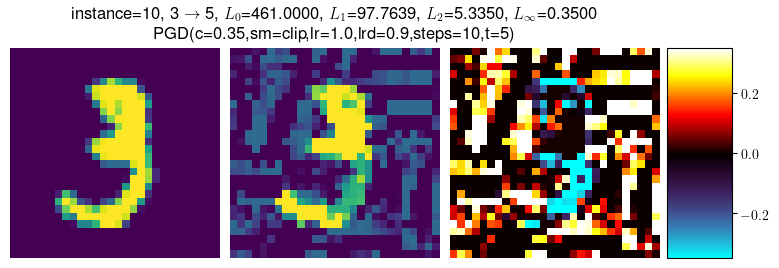

5: 5 -> 5 $L_0$=413.0000, $L_1$=85.9899, $L_2$=4.9660, $L_\infty$=0.3500


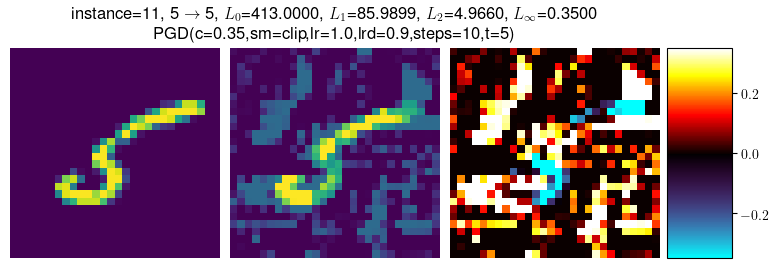

3: 3 -> 5 $L_0$=480.0000, $L_1$=102.3985, $L_2$=5.4866, $L_\infty$=0.3500


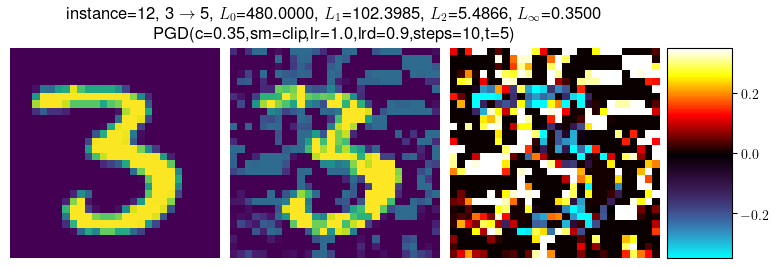

6: 6 -> 5 $L_0$=450.0000, $L_1$=97.4241, $L_2$=5.3352, $L_\infty$=0.3500


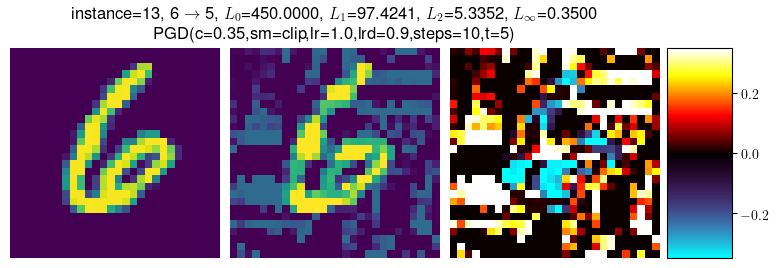

1: 1 -> 5 $L_0$=417.0000, $L_1$=92.6922, $L_2$=5.2047, $L_\infty$=0.3500


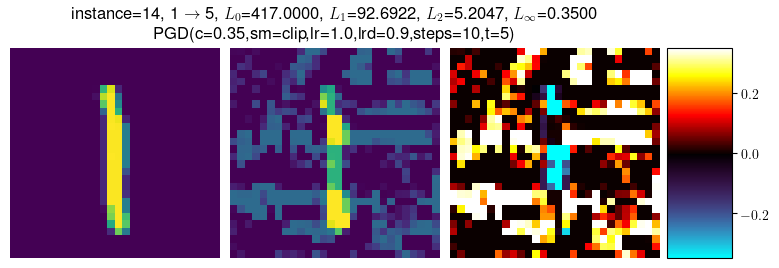

7: 7 -> 5 $L_0$=471.0000, $L_1$=110.0157, $L_2$=5.7452, $L_\infty$=0.3500


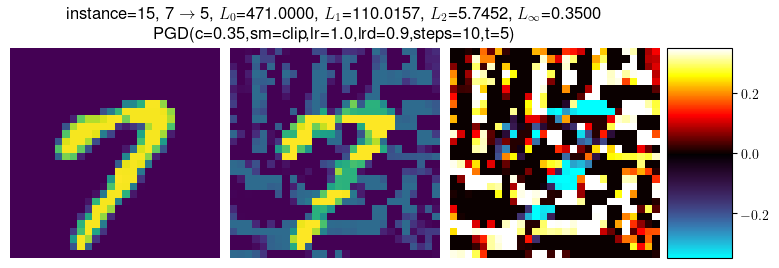

In [5]:
att = hw4_part1.PGDAttacker(
        model=m,
        num_steps = 10,
        target=5,
        learning_rate_decay=0.9,
        learning_rate=1.0,
        step_mode="clip",
        c=0.35
    )

att.evaluate(
    X=mnist_data.train.X[0:16*1],
    Y=mnist_data.train.Y[0:16*1],
    display_progress=True
)
show_attack(att, np.arange(0, 16), mnist_data.train)

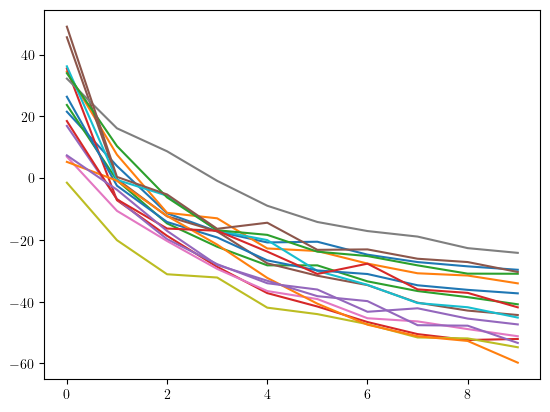

Success rate:  0.875
Mean Distortion:  $L_0$=139.1429, $L_1$=42.6818, $L_2$=5.6742, $L_\infty$=1.0000


5: 5 -> 5 $L_0$=187.0000, $L_1$=40.0913, $L_2$=4.9815, $L_\infty$=1.0000


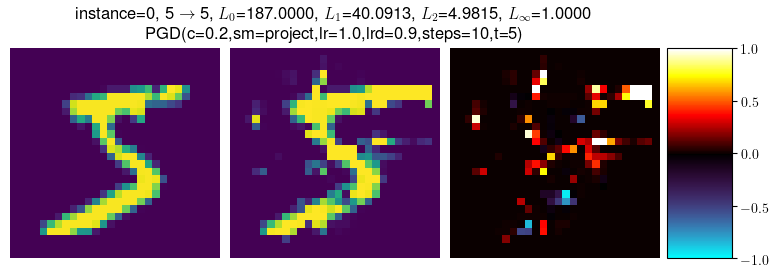

0: 0 -> 5 $L_0$=147.0000, $L_1$=36.4596, $L_2$=5.0698, $L_\infty$=1.0000


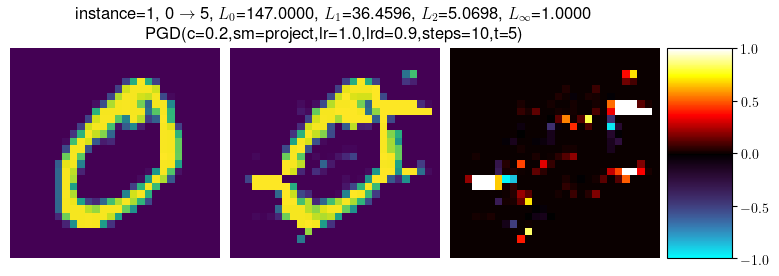

4: 4 -> 5 $L_0$=120.0000, $L_1$=34.3661, $L_2$=5.0143, $L_\infty$=1.0000


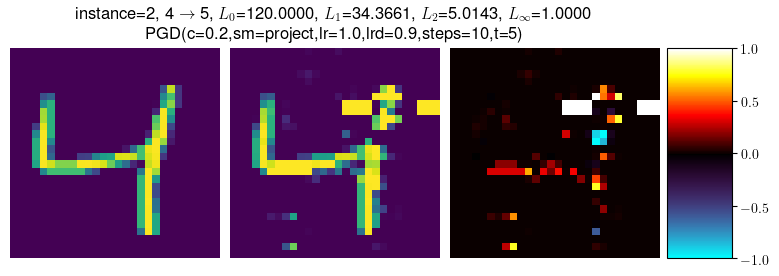

1: 1 -> 5 $L_0$=112.0000, $L_1$=42.4826, $L_2$=5.8164, $L_\infty$=1.0000


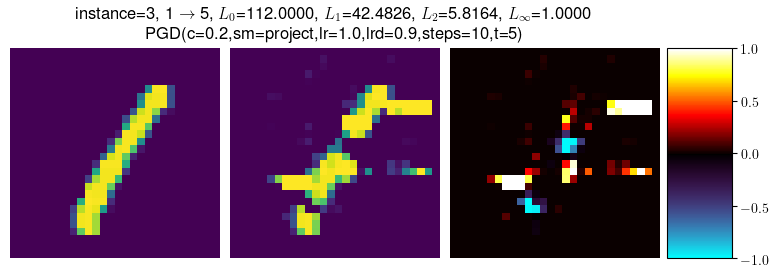

9: 9 -> 5 $L_0$=134.0000, $L_1$=46.3217, $L_2$=5.8178, $L_\infty$=1.0000


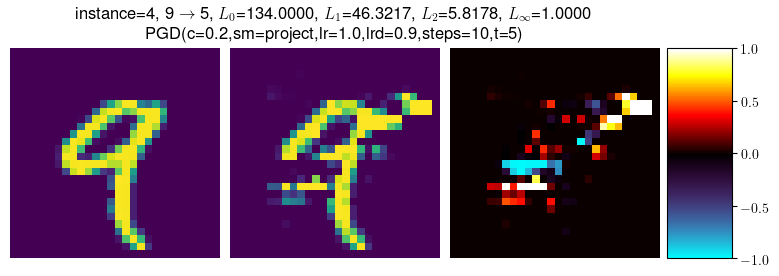

2: 2 -> 5 $L_0$=135.0000, $L_1$=32.2475, $L_2$=4.6659, $L_\infty$=1.0000


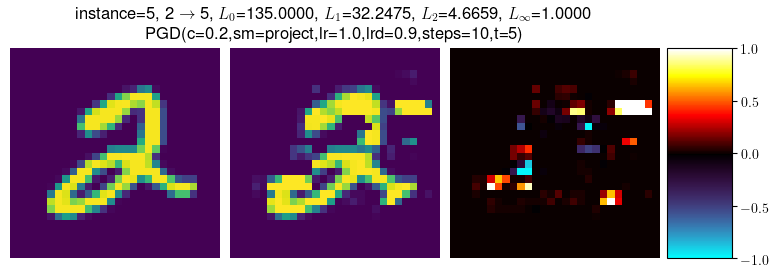

1: 1 -> 5 $L_0$=131.0000, $L_1$=40.0076, $L_2$=5.6174, $L_\infty$=1.0000


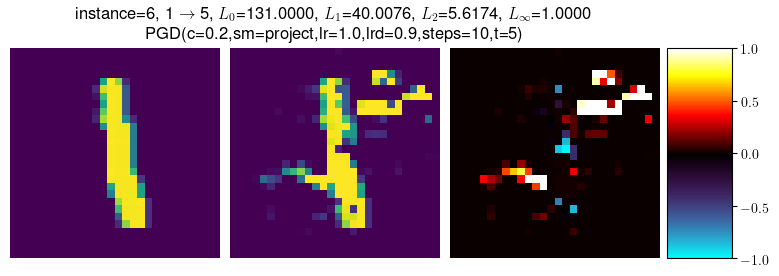

3: 3 -> 5 $L_0$=193.0000, $L_1$=43.1679, $L_2$=5.4127, $L_\infty$=1.0000


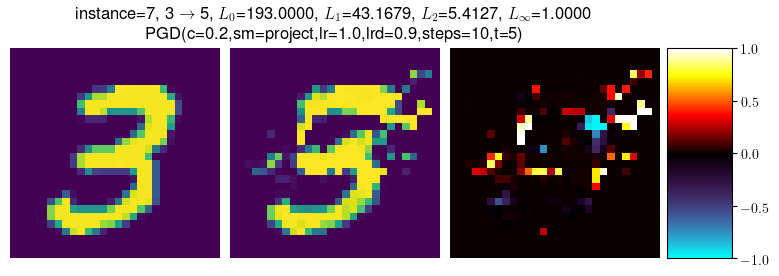

1: 1 -> 5 $L_0$=118.0000, $L_1$=46.7087, $L_2$=6.1588, $L_\infty$=1.0000


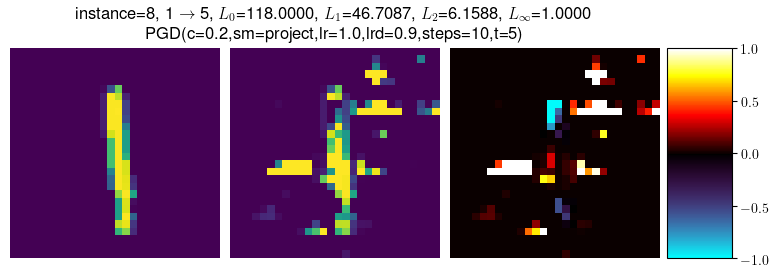

4: 4 -> 5 $L_0$=124.0000, $L_1$=46.6257, $L_2$=6.0385, $L_\infty$=1.0000


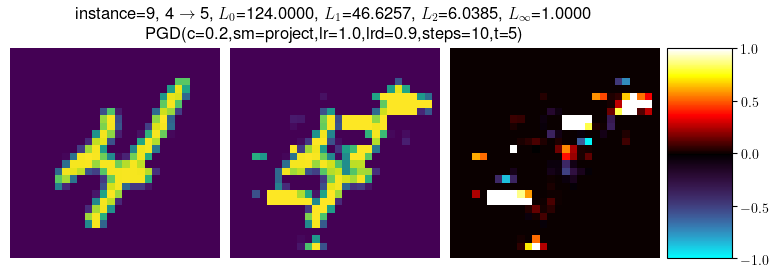

3: 3 -> 5 $L_0$=124.0000, $L_1$=45.3717, $L_2$=6.0761, $L_\infty$=1.0000


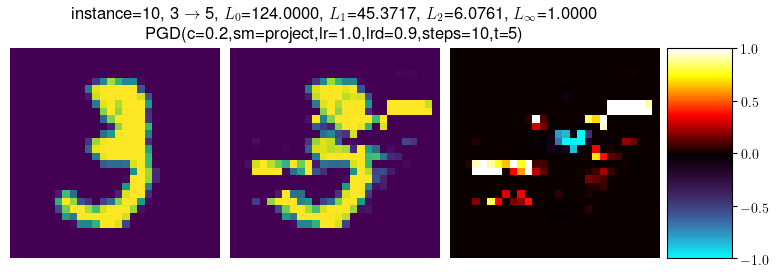

5: 5 -> 5 $L_0$=141.0000, $L_1$=36.3874, $L_2$=4.8301, $L_\infty$=1.0000


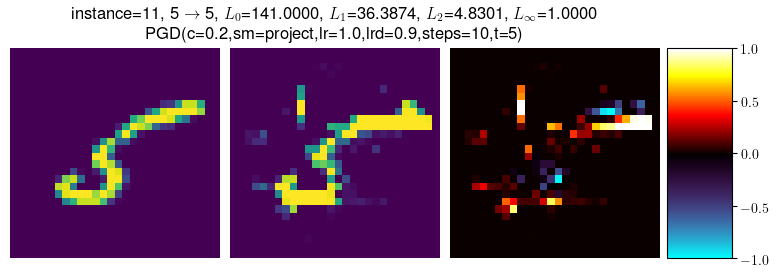

3: 3 -> 5 $L_0$=144.0000, $L_1$=41.3981, $L_2$=5.6404, $L_\infty$=1.0000


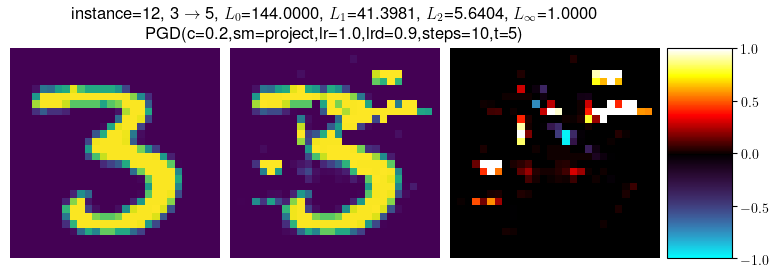

6: 6 -> 5 $L_0$=167.0000, $L_1$=51.3882, $L_2$=6.1520, $L_\infty$=1.0000


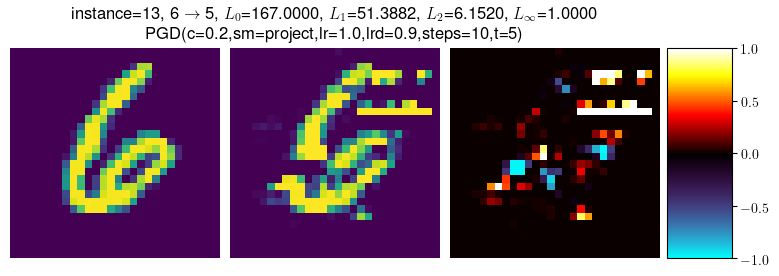

1: 1 -> 5 $L_0$=123.0000, $L_1$=43.8688, $L_2$=6.1038, $L_\infty$=1.0000


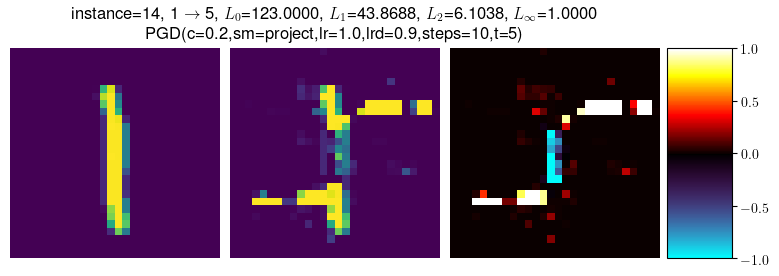

7: 7 -> 5 $L_0$=176.0000, $L_1$=47.1312, $L_2$=5.8543, $L_\infty$=1.0000


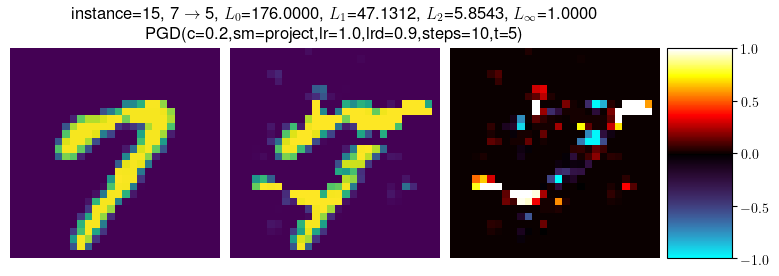

In [6]:
att = hw4_part1.PGDAttacker(
        model=m,
        num_steps = 10,
        target=5,
        learning_rate_decay=0.9,
        learning_rate=1.0,
        step_mode="project",
        c=0.2
    )

att.evaluate(
    X=mnist_data.train.X[0:16*1],
    Y=mnist_data.train.Y[0:16*1],
    display_progress=True
)
show_attack(att, np.arange(0, 16), mnist_data.train)

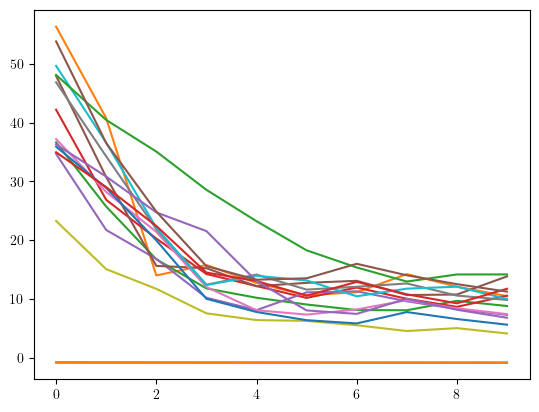

Success rate:  0.875
Mean Distortion:  $L_0$=784.0000, $L_1$=40.1413, $L_2$=3.1164, $L_\infty$=0.9041


5: 5 -> 5 $L_0$=784.0000, $L_1$=17.0732, $L_2$=0.6372, $L_\infty$=0.0243


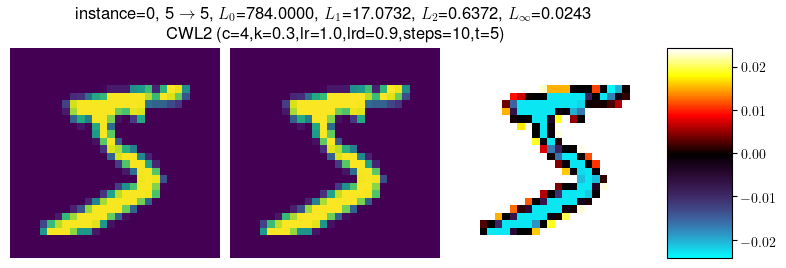

0: 0 -> 5 $L_0$=784.0000, $L_1$=43.5414, $L_2$=3.4212, $L_\infty$=0.9764


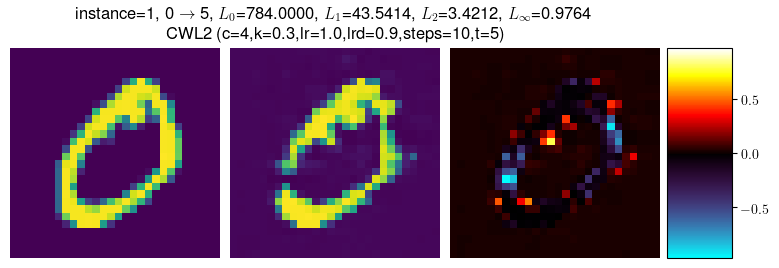

4: 4 -> 5 $L_0$=784.0000, $L_1$=37.0775, $L_2$=2.9227, $L_\infty$=0.9910


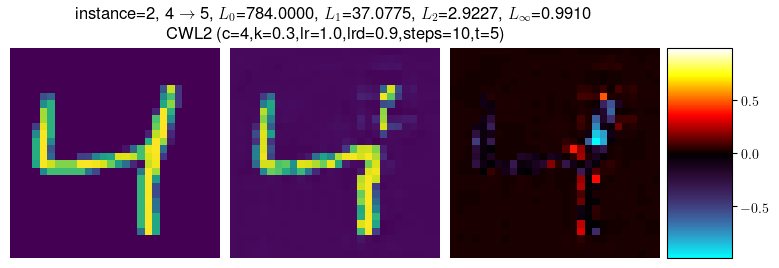

1: 1 -> 5 $L_0$=784.0000, $L_1$=37.6922, $L_2$=3.1456, $L_\infty$=0.9130


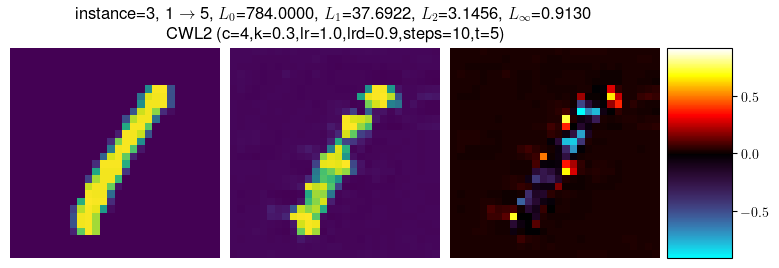

9: 9 -> 5 $L_0$=784.0000, $L_1$=37.0736, $L_2$=2.9206, $L_\infty$=0.8674


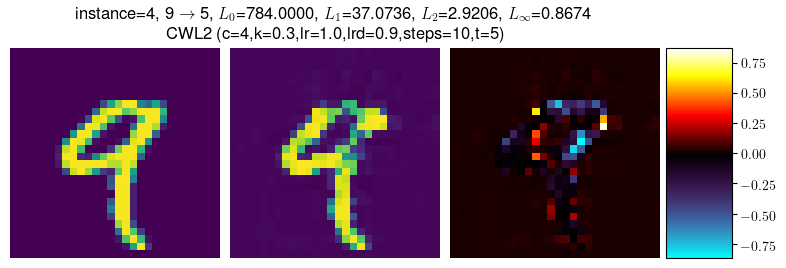

2: 2 -> 5 $L_0$=784.0000, $L_1$=48.6077, $L_2$=3.4500, $L_\infty$=0.9109


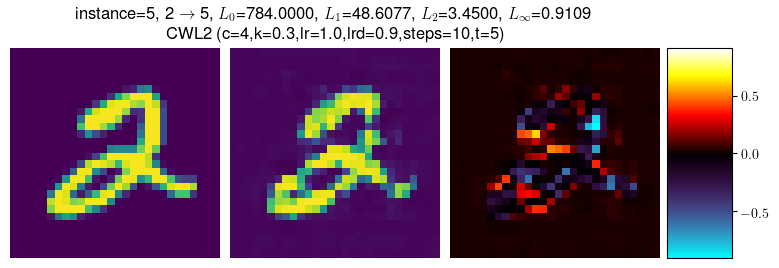

1: 1 -> 5 $L_0$=784.0000, $L_1$=35.7272, $L_2$=2.9281, $L_\infty$=0.9746


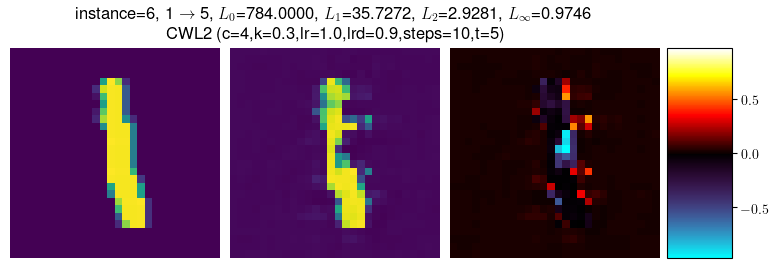

3: 3 -> 5 $L_0$=784.0000, $L_1$=39.6936, $L_2$=3.1868, $L_\infty$=0.8839


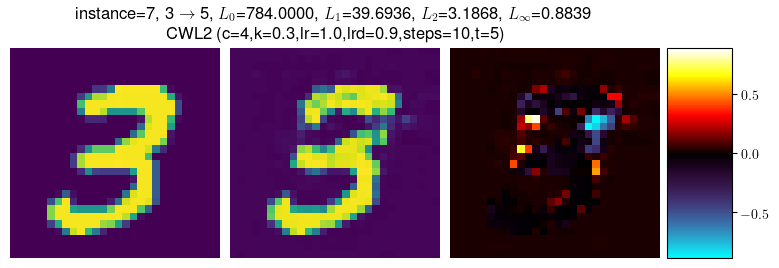

1: 1 -> 5 $L_0$=784.0000, $L_1$=32.1692, $L_2$=2.3169, $L_\infty$=0.6210


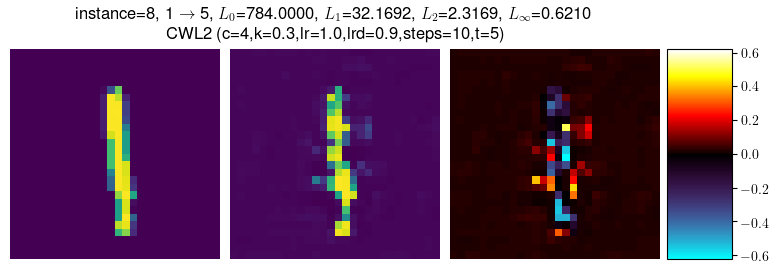

4: 4 -> 5 $L_0$=784.0000, $L_1$=44.4645, $L_2$=3.3513, $L_\infty$=0.9320


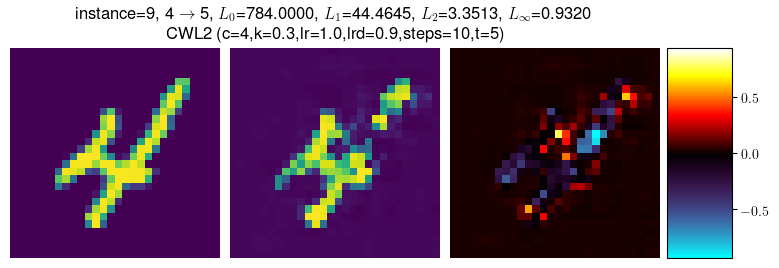

3: 3 -> 5 $L_0$=784.0000, $L_1$=34.3115, $L_2$=2.6195, $L_\infty$=0.9779


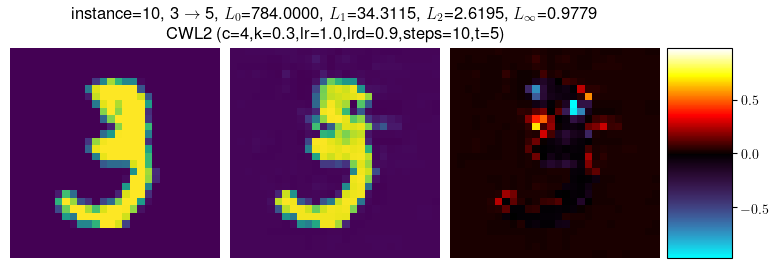

5: 5 -> 5 $L_0$=783.0000, $L_1$=17.8141, $L_2$=0.6532, $L_\infty$=0.0243


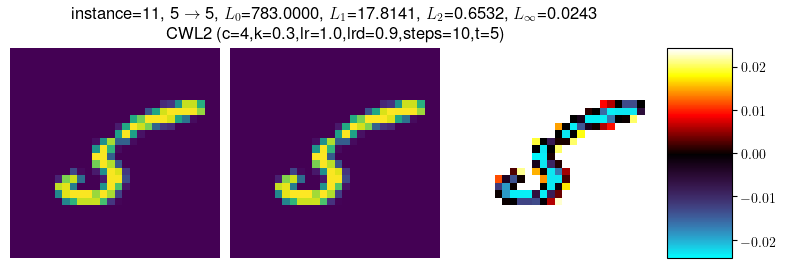

3: 3 -> 5 $L_0$=784.0000, $L_1$=48.1112, $L_2$=3.7676, $L_\infty$=0.9249


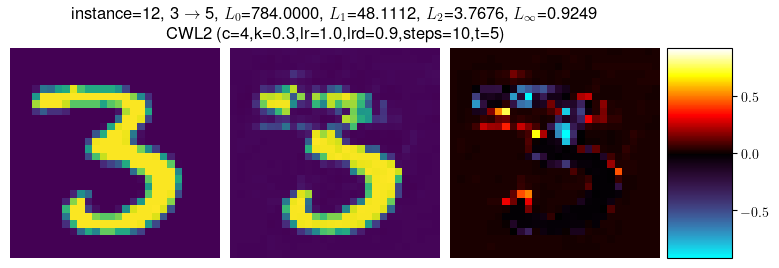

6: 6 -> 5 $L_0$=784.0000, $L_1$=43.2162, $L_2$=3.2298, $L_\infty$=0.9503


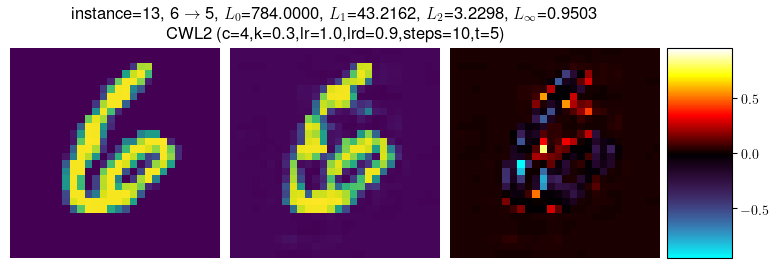

1: 1 -> 5 $L_0$=784.0000, $L_1$=37.2718, $L_2$=2.8361, $L_\infty$=0.7898


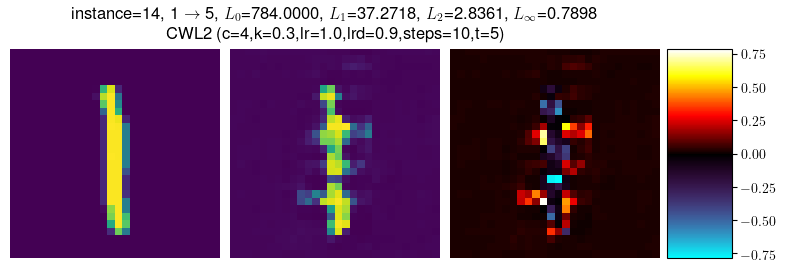

7: 7 -> 5 $L_0$=784.0000, $L_1$=43.0208, $L_2$=3.5333, $L_\infty$=0.9448


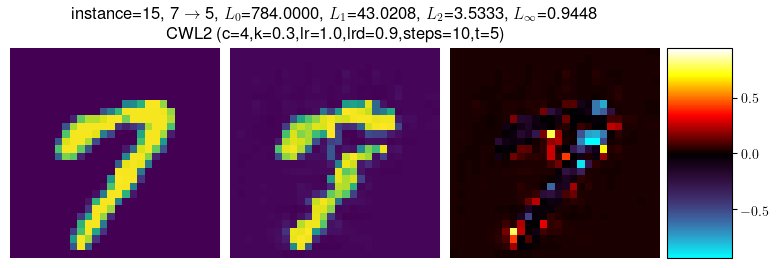

In [7]:
att = hw4_part1.CWL2Attacker(
    model=m,
    num_steps=10,
    target=5,
    learning_rate=1.0,
    learning_rate_decay=0.9,
    k=0.3,
    c=4
)

att.evaluate(
    X=mnist_data.train.X[0:16*1],
    Y=mnist_data.train.Y[0:16*1],
    display_progress=True
)
show_attack(att, np.arange(0, 16), mnist_data.train)